# Covid Impact on Bike Rentals in NYC
<br/>

Citi Bike, in New York City, is the largest bike share system in the U.S. Since launching in May 2013, Citi Bike has grown in size and popularity, currently offering a fleet of over 14,000 bikes, accessible at nearly 900 stations across Manhattan, Brooklyn, Queens and Jersey City. Bike share programs provide many benefits in larger cities where owning a car is not an affordable or feasible option. If you are interested in learning more about bike share programs in general, this [article](https://www.moneycrashers.com/bike-sharing-best-bike-share-programs/) on moneycrashers.com provides a decent overview along with nice breakdown of the pros and cons.

The date as I wrap up this project is June 15, 2020 and New York state is slowly starting the process of reopening following the shelter-in-place order issued on March 22. It remains to be seen just how long it will take for things to truly get back to normal. In the meantime, I thought it would be interesting to analyze bike rental data from 2019 and 2020 to see what affect, if any, the pandemic has had on NYC's bike share program. 

<br/>

<img src="../img/bike-esb.png"
     alt="Citi Bike with the Empire State Building in the background"
     style="float: left; margin-right: 10px;" />
     
<br/>

## 1. A story in 12 million rows
<br/>

From a data science perspective, there are at least three great things about bike share programs:

1. They *usually* share a good portion of their data freely with the public
2. The data is *mostly* clean and ready to go for analysis
3. They can be a great source for getting *a lot* of data for a project (\**depending on the program*)



Citi Bike is no exception to the above, providing their data in a few different formats if you want to dig in and learn more. You can visit the main [System Data page](https://www.citibikenyc.com/system-data) as a good starting point for your analysis. If you want the raw data by month though, head directly over to the [tripdata index](https://s3.amazonaws.com/tripdata/index.html).


### The data

The data files are available in csv format with the following fields:

- **tripduration** - length of rental in seconds
- **starttime** - rental start time
- **stoptime** - rental stop time
- **start station id** - id of start station 
- **start station name** - friendly name of start station
- **start station latitude** - latitude of start station
- **start station longitude** - longitude of start station
- **end station id** - id of end station
- **end station name** - friendly name of end station
- **end station latitude** - latitude of end station
- **end station longitude** - longitude of end station
- **bikeid** - id of rental bike
- **usertype** - type of user ('Subscriber' or 'Customer')
- **birth year** - birth year of renter (if known)
- **gender** - gender of renter (if known)


### The analysis

For this project, I am interested in comparing data between 2019 and 2020 to investigate the impact of Covid-19 on the overall bike share program. The monthly rollups always lag behind by about a month, so this project will focus on the period between January and May for both 2019 and 2020. All in all, this will provide over 11 million rows of data for our analysis.

#### The primary questions I seek to answer with this research are:
    
1. What is the effect, if any, of Covid-19 on the total number of bike rentals and average rentals per day?
<br/>

2. What is the effect, if any, of Covid-19 on the average bike rental duration?
<br/>

3. Are there any significant, observable patterns in the data along the dimensions of Age, Gender or Customer Type?
<br/>

4. Are there any perceptible shifts in rider behavior in terms of rides by hour of day or day of the week?
<br/>

5. Based on the above analysis and a simplified model for projecting pricing information, what is the projected impact on program revenue?
<br/>

*(Time-permitting or as a potential follow up project, it would be interesting to see if there are any significant observable geographical differences in terms of station or route popularity?)*


TODO - State the hypothesis and the null hypothesis.


Let's get started!


### Import packages


In [1]:
import glob
import numpy as np
import pandas as pd
import math
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', color_codes=True, font_scale=1.25)

pd.set_option('display.float_format', lambda x: '%.2f' % x) # Set display option for floats in Pandas

from IPython.display import Markdown, display # To add markdown inline with code


### Create some helper functions for reading and processing the data

One lesson I learned pretty quickly on this project was that creating a dataframe with 10+ million rows of data can eat up memory quickly. My initial attempt to read in and concatenate all the files resulted in a massive dataframe utilizing about <ins>**4+ GB**</ins> of my system memory. Needless to say, this brought my analysis to a halt. Determined to press on, I did some research on memory usage in Pandas and Jupyter Notebook and found a few strategies I thought might help.

<br/>
There are some great resources out there if you want to read more about the topic. I relied on this [article](https://www.dataquest.io/blog/pandas-big-data/) from DataQuest to get me pointed down the right path. If I had to sum this up into a couple of key nuggets though, they would be:

1. **Dtype matters** <br/> Optimizing your dtypes can result in up to 75% savings in memory usage in the right circumstances 
<br/>

2. **Dtype especially matters if it's an object** <br/> Storing column data as an object dtype is pretty much the least efficient way to go when it comes to memory usage. Change to a more optimized dtype, or better yet, remove the data if you aren't going to use it
<br/>

3. **Only keep the data you need** <br/> See points made directly above... if you aren't using the data for your analysis, don't keep it
<br/>

4. **A pivoted dataframe will speed up your plots** <br/> For my analysis, I'm looking for broad trends in the data. I don't need to plot every point. Your mileage may vary based on the needs of your project, but a pivoted dataframe with ~100 rows of data will plot faster than 10 million rows any day of the week.
<br/>

The following are a few helper functions to facilitate optimizing the files during the read-in process and to assist with pivoting the data for my plots once we get into the analysis. After optimization, I managed to get the overall memory usage down to just over 1 GB from the original ~4 GB, which greatly improved performance.
<br/>

In [2]:
###TODO - Improve function docstrings

# Function for reading in and processing data files
def read_and_process(filepath, col_types, drop_cols, get_stations=False):
    '''Reads in and processes CitiBike monthly csv data files and returns a 
    dataframe containing the list of rentals for a given month
    '''
    # Read in the data
    temp_df = pd.read_csv(filepath) 
    
    # Drop rows with null values
    temp_df = temp_df.dropna()
    
    # Convert starttime columns to datetime
    temp_df.starttime = pd.to_datetime(temp_df.starttime, infer_datetime_format=True)
    
    # Convert usertype column to binary
    temp_df.usertype = temp_df.usertype.map({"Subscriber": 0, "Customer": 1})
    
    # Convert column dtypes
    temp_df = temp_df.astype(col_types)
    
    if get_stations == True:  # Process station data
        temp_stations = process_station_data(temp_df)  
    
    # Drop unnecessary or redundant columns
    temp_df = temp_df.drop(drop_cols, axis=1)
    
    # Rename columns to replace spaces with "_"
    temp_df.columns = temp_df.columns.str.replace(" ", "_")
    
    # Return df object(s) based on params
    if get_stations == True: 
        return temp_df, temp_stations
    else:
        return temp_df


# Function for abstracting out station-related data for location-based analysis
def process_station_data(df):
    '''Processes and abstracts station-related data and returns as a separate dataframe
    '''
    # New column names
    cols = ['id', 'name', 'lat', 'lon']

    # Temp df for start stations
    start_stations = df[['start station id', 'start station name',
                         'start station latitude', 'start station longitude']]
    start_stations.columns = cols
    start_stations = start_stations.drop_duplicates()

    # Temp df for end stations
    end_stations = df[['end station id', 'end station name',
                       'end station latitude', 'end station longitude']]
    end_stations.columns = cols
    end_stations = end_stations.drop_duplicates()
    
    # Concatenate the start/end station dfs and drop dups 
    temp_stations = pd.concat([start_stations, end_stations],
                              ignore_index=True).drop_duplicates()
    
    return temp_stations

### Prep for import and read in the data

Now that we have a couple of helper functions to get us started, we're ready to read in the data files. First we will create a few variables required for input into the **read_and_process** function and then it's off to the races. (Actually, this part take a couple of minutes to complete, so see you on the other side.)

#### TODO - Describe the rationale behind abstracting out the station data
#### TODO - What fields are being transformed and why? What fields are being dropped and why?


In [3]:
# Dictionary of columns and optimal dtypes
col_types = {'start station id' : 'int', 'end station id': 'int',
             'usertype': 'int8', 'birth year': 'int', 'gender': 'int8'}

# Create list of columns to drop
drop_cols = ['stoptime', 'start station name', 'start station latitude',
             'start station longitude', 'end station name', 'end station latitude',
             'end station longitude', 'bikeid']

# Read in and process the data
data_files = glob.glob('../data/' + "*.csv")
rentals_dfs = []

for file in data_files:
    rentals_df = read_and_process(file, col_types, drop_cols)
    rentals_dfs.append(rentals_df)

# Concatentate the list of temp dfs
df = pd.concat(rentals_dfs, ignore_index=True)

# Check out the data!
rows = df.shape[0]
print(str(rows) + " Rows")

12556146 Rows



### Data preview and cleanup

Next, let's spend some time previewing and cleaning the data before generating the final dataframe for analysis. First, we'll do a check for null values in both the rentals and stations dataframes. Then we'll take a look at some of the descriptive statistics to get a feel for the overall data quality.

In [4]:
# Check for null values
df.isna().sum()

tripduration        0
starttime           0
start_station_id    0
end_station_id      0
usertype            0
birth_year          0
gender              0
dtype: int64

In [5]:
# Review the descriptive stats
df.describe()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender
count,12556146.00,12556146.00,12556146.00,12556146.00,12556146.00,12556146.00
mean,1055.92,1744.07,1735.19,0.14,1979.82,1.17
std,11043.14,1492.98,1492.78,0.34,12.22,0.54
min,61.00,72.00,72.00,0.00,1857.00,0.00
25%,356.00,391.00,389.00,0.00,1969.00,1.00
50%,622.00,522.00,520.00,0.00,1982.00,1.00
75%,1144.00,3324.00,3323.00,0.00,1990.00,1.00
max,3786187.00,4021.00,4021.00,1.00,2004.00,2.00


#### Summary and next steps
As expected, our processing step eliminated any null values as part of reading in the data, so we don't have anything to deal with there. Looking at the descriptive statistics, it appears we may need to do some additional processing on the **tripduration** and **birth_year** columns, so we'll take a look at those individually starting with the tripduration column.


### Trip duration review

The raw data from Citi Bike includes tripduration in the unit of seconds. Based on the output above, we can see that the minimum trip is just over one minute and the maximum trip clocks in at **over 63,000 minutes**! In addition, the standard deviation for the column seems high (~185 minutes) give that the 75th percentile is sitting at about 20 minutes.

Let's review the distribution to decide how to move forward.

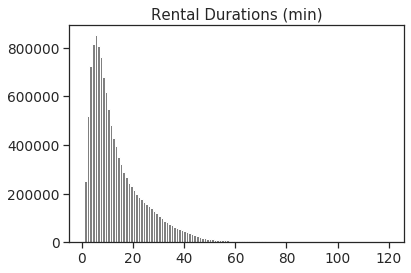

In [6]:
# Convert durations to minutes
x = df.tripduration / 60

# Plot as a histogram with a range up to 2 hours
plt.hist(x, bins=120, range=(1,120), color='gray')
plt.title('Rental Durations (min)');


#### Duration distribution results

Based on the histogram, it looks like our distribution is skewed heavily to the right which makes sense given the descriptive statistics we observed above. From this view, it appears that the number of trips starts to drop off almost entirely at the 60 minute mark. Let's drill in and see what percentage of trips are greater than 1 or 2 hours in length.

In [7]:
# Get a count of the number of trips over 60 minutes and 2 hours
trips_over_60 = df.tripduration[df.tripduration > 3600].count() / df.tripduration.count()
trips_over_90 = df.tripduration[df.tripduration > 5400].count() / df.tripduration.count()
trips_over_120 = df.tripduration[df.tripduration > 7200].count() / df.tripduration.count()

print("The percentage of trips over 60 minutes is " + str(round((trips_over_60 * 100),2)) + "%")
print("The percentage of trips over 90 minutes is " + str(round((trips_over_90 * 100),2)) + "%")
print("The percentage of trips over 120 minutes is " + str(round((trips_over_120 * 100),2)) + "%")

The percentage of trips over 60 minutes is 1.4%
The percentage of trips over 90 minutes is 0.65%
The percentage of trips over 120 minutes is 0.4%


In [8]:
# Get a count of the number of trips under 2 minutes and 5 minutes
trips_under_90sec = df.tripduration[df.tripduration < 90].count() / df.tripduration.count()
trips_under_2 = df.tripduration[df.tripduration < 120].count() / df.tripduration.count()
trips_under_5 = df.tripduration[df.tripduration < 300].count() / df.tripduration.count()

print("The percentage of trips under 90 seconds is " + str(round((trips_under_90sec * 100),2)) + "%")
print("The percentage of trips under 2 minutes is " + str(round((trips_under_2 * 100),2)) + "%")
print("The percentage of trips under 5 minutes is " + str(round((trips_under_5 * 100),2)) + "%")

The percentage of trips under 90 seconds is 0.74%
The percentage of trips under 2 minutes is 2.02%
The percentage of trips under 5 minutes is 18.66%



#### Identifying outliers

On the upper end of duration, almost one and a half percent of trips exceed an hour with less than half of a percent of trips exceeding 2 hours. Things get a bit more interesting on the lower end of the spectrum where two percent of trips clock in at less than 2 minutes with **almost one percent under 90 seconds!** This seems like a very short trip to make on a rental bike and hardly worth the effort of renting. 

Since the goal of the analysis is to look for differences between 2019 and 2020, let's compare the data between years before making a final decision on outliers.

In [9]:
# Compare 2019 trips to 2020
pct_2019_under_90 = df[(df.starttime < '2020-01-01 00:00:00') & (df.tripduration < 90)].\
               tripduration.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_under_90 = df[(df.starttime > '2019-12-31 11:59:59') & (df.tripduration < 90)].\
               tripduration.count() / df[df.starttime > '2019-12-31 11:59:59'].tripduration.count()
print("2019 Under 90 sec: " + str(round((pct_2019_under_90 * 100),5)) + "%")
print("2020 Under 90 sec: " + str(round((pct_2020_under_90 * 100),5)) + "%")

pct_2019_over_120 = df[(df.starttime < '2020-01-01 00:00:00') & (df.tripduration > 7200)].\
               tripduration.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_over_120 = df[(df.starttime > '2019-12-31 11:59:59') & (df.tripduration > 7200)].\
               tripduration.count() / df[df.starttime > '2019-12-31 11:59:59'].tripduration.count()
print("2019 Over 2 hr: " + str(round((pct_2019_over_120 * 100),5)) + "%")
print("2020 Over 2 hr: " + str(round((pct_2020_over_120 * 100),5)) + "%")

2019 Under 90 sec: 0.71007%
2020 Under 90 sec: 0.77604%
2019 Over 2 hr: 0.27915%
2020 Over 2 hr: 0.55759%



#### Removing outliers

There is a slight difference in the percentage of trips under 90 seconds and over 2 hours when comparing 2019 and 2020, but it seems insignificant enough (0.066% on the low end and 0.5% on the high end, respectively) as to not affect our final results. Before we move on to review the birth_year data, let's remove these rows from our dataframe. 


In [10]:
# Remove outlier trips with above 120 min
df = df[(df.tripduration >= 90) | (df.tripduration <= 7200)]


### Birth year review

Revisiting the descriptive statistics above, we see a spread of birth years ranging from 1857-2004. While it definitely feels likely that there are riders as young as 16, it's doubtful we have riders who are **163 years old**.

Again, let's start with a histogram view and then decide on next steps.

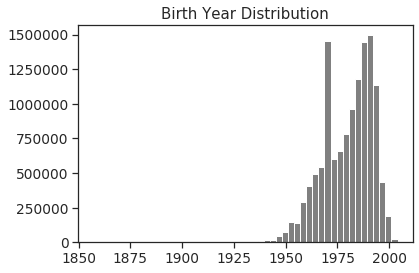

In [11]:
# Convert durations to minutes
x = df.birth_year

# Plot as a histogram with a range up to 2 hours
plt.hist(x, bins=50, range=(1857,2004), color='gray')
plt.title('Birth Year Distribution');

In [12]:
# Calculate the percent of rows with riders older than 90
pct_over_90 = round((df[df.birth_year < 1930].birth_year.count() / df.birth_year.count() * 100),2)
print("Overall percent over 90: " + str(pct_over_90) + "%")

pct_2019_over_90 = df[(df.starttime < '2020-01-01 00:00:00') & (df.birth_year < 1930)].\
               birth_year.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_over_90 = df[(df.starttime > '2019-12-31 11:59:59') & (df.birth_year < 1930)].\
               birth_year.count() / df[df.starttime > '2019-12-31 11:59:59'].tripduration.count()
print("2019 percent over 90: " + str(round((pct_2019_over_90 * 100),5)) + "%")
print("2020 percent over 90: " + str(round((pct_2020_over_90 * 100),5)) + "%")

Overall percent over 90: 0.06%
2019 percent over 90: 0.06315%
2020 percent over 90: 0.05705%


#### Removing outliers

For birth-year, we could consider replacing the outlier values by imputing with the column average or by some other means. But, given that the number of rows with riders over 90 years old is relatively small overall and is consistent between 2019 and 2020, we should be safe to remove these completely.

There is also an interesting spike in the distribution right around 1970. After removing the outlier age range, let's take a look at the spike in greater detail. 

In [13]:
# Remove outlier trips with riders older than 90
df = df[df.birth_year >= 1930]

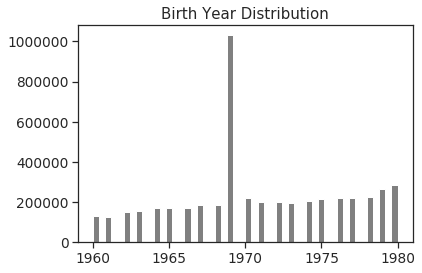

In [14]:
# Plot as a histogram with a range up to 2 hours
plt.hist(x, bins=50, range=(1960,1980), color='gray')
plt.title('Birth Year Distribution');


#### Baby boom in 1969??

This is tough to explain with the data we have to available for analysis, but there appears to be a huge spike in riders with a birth year of 1969. Unfortunately, we don't have much additional data to use to understand what's causing this spike. We could calculate the probability of this occuring, but it's obviously too dramatic a spike to be the result of pure chance. 

Some possible explanations:
1. 1969 is the default birth year on the registration form (doubtful)
<br/>

2. Generally, people have some affinity for the year 1969 (possible)
<br/>

3. Older riders are less likely to be honest about their true birth year (possible)
<br/>

4. There is a price break or discount for riders older than 50 (probable)
<br/>

In any case, this brings us to a decision point. If we remove all or most of the rows with this birtyh year, we lose nearly 10% of our data. If we assign random birth years to these rows based on our distribution, we run the risk of greatly skewing any age-related analysis. For now, let's leave this alone and revisit when we get to analyzing rider behavior by age group. 


### Checking for correlation

Before moving on to the final cleanup steps, let's review our current dataframe for correlation to see check for any interesting relationships between variables. 

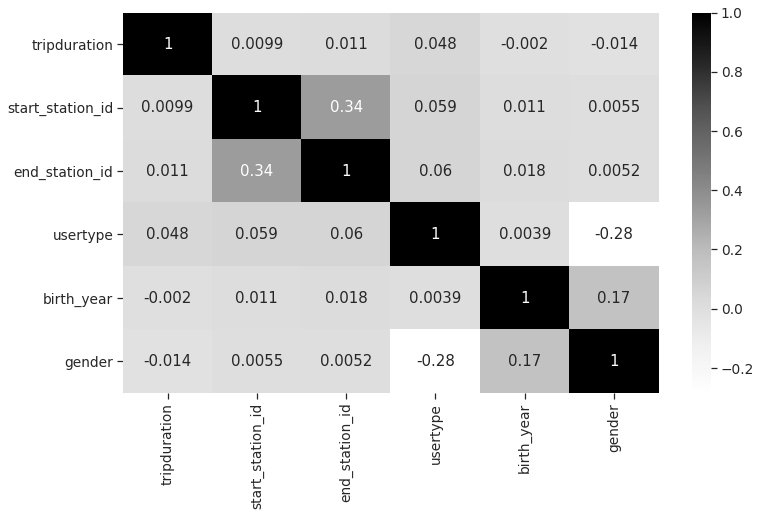

In [17]:
# Create correlation matrix
fig, ax = plt.subplots(figsize=(12, 7))  
sns.heatmap(df.corr(), annot=True, cmap="Greys")
plt.show()


#### Correlation results

Even with our skewed birth_year data, there really doesn't appear to be much of a relationship between our different variables. There is a slight positive correlation between `start_station_id` and `end_station_id` which would make sense if people tend to follow the same routes repeatedly (e.g., when commuting). We can take a look at this later (assuming we get to the geographic analysis) or save as a *TODO* for follow up.



### Additional columns to aid analysis

To facilitate our analysis and to help in our plotting throughout, we'll add a few more columns for rental count and for date related info (hour, day, month, year). 

If memory is at a premium, why add these columns now? The simple answer is that these columns will make pivoting the data by month and year much easier throughout the notebook. And, since they all go in as int columns, the additional size will be somewhat negligible. Additionally, once we've extracted this data we'll be able to drop the `starttime` column to reclaim some memory.

(Note - I could do more to optimize the specific type of int column - int8, int16, int32, etc. - but in playing around with this, I didn't see much improvement in overall performance. I'll save that optimization as a TODO for later.)

Following this step, we'll have our final dataframe ready to go for analysis.

In [18]:
# Sort the dfs by starttime
df = df.sort_values(by=['starttime']).reset_index(drop=True)

# Create a column to facilitate totaling rental count
df['rental_count'] = 1

# Create a function to get the dow of the week as an int value
def get_dow(starttime):
    """Returns day of the week as an integer (0-6) when passed a datetime object
    """
    return starttime.weekday()

# Create new columns for day, month and year
df['hour'] = df.starttime.dt.hour
df['day'] = df.starttime.dt.day
df['month'] = df.starttime.dt.month
df["year"] = df.starttime.dt.year
df['dow'] = df.starttime.apply(get_dow)

# Drop starttime column
df = df.drop('starttime', axis=1)


## 2. So how does a global pandemic affect bike rentals anyway?
<br/>

Now that we have the final dataframe, we can dig into the analysis. The first question on the list is... What is the effect, if any, of Covid-19 on the total number of bike rentals and average rentals per day?

Before we go further though, we'll create an additional helper function for pivoting the dataframe which will help speed up our plotting from here on out. 

In [20]:
###TODO - Improve function docstrings

# Function for pivoting dataframe for plotting
def pivot_df(df, pv_index, pv_columns, pv_values, scale, aggfunc=np.sum, impute=False,
             cumsum=False, pv_cumsum=False):
    """Returns a pivoted version of a dataframe to aid in plotting
    """
    # Create pivot table
    df_pivot = df.pivot_table(index=pv_index, columns=pv_columns, values=pv_values, aggfunc=aggfunc)

    # Impute values for 2019-02-29 to account for leap year in 2020 
    if impute == True:
        df_pivot = df_pivot.fillna(df_pivot[2019].mean())

    # Convert to running total
    if cumsum == True:
        df_pivot = df_pivot.cumsum()
    
    # Convert to a running total by facet
    if pv_cumsum == True:
        for i in range(2,5,1):
            for n in range(3):
                df_pivot.xs((i,n))[2019] = df_pivot.xs((i,n))[2019] + df_pivot.xs((i-1,n))[2019]
                df_pivot.xs((i,n))[2020] = df_pivot.xs((i,n))[2020] + df_pivot.xs((i-1,n))[2020]    
                
    # Scale values 
    df_pivot = df_pivot.apply(lambda x: round((x * scale),2), axis=1)
    
    return df_pivot


### Total rentals by month, 2019 vs. 2020


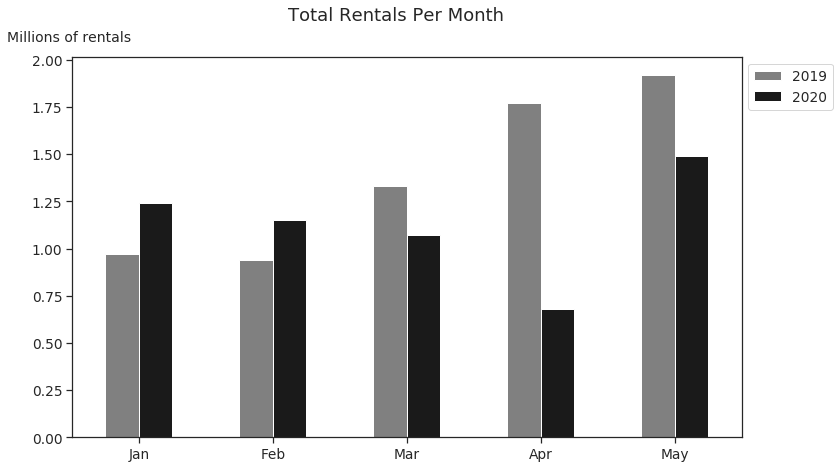

In [21]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month'], ['year'], 'rental_count', 0.000001)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.05, .91, 'Millions of rentals', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Total Rentals Per Month", fontsize=18)
# plt.title("(CitiBike NYC)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

### Running total of rentals by day, year-over-year

Next, let's drill into total cumulative rental counts by day to see if we can detect the point that rental numbers started dropping off. For this plot, I've added vertical lines corresponding with a couple of key dates related to Covid-19.

- **March 11** - Covid-19 Declared a Global Pandemic
- **March 22** - New York state under order to *shelter-in-place*

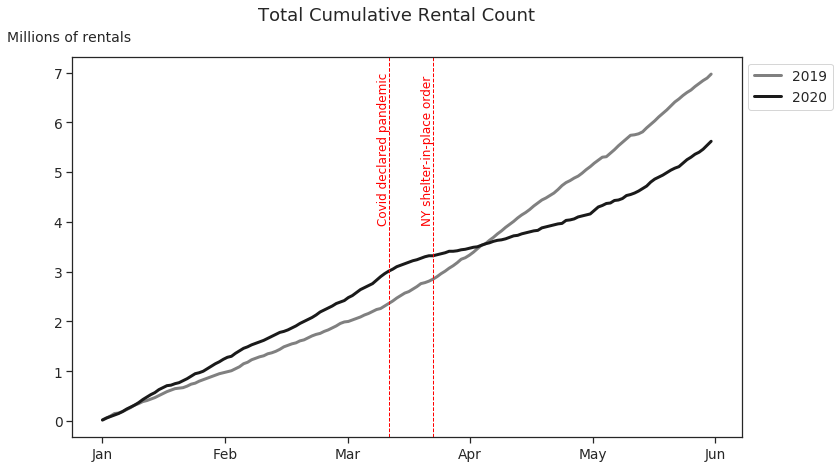

In [22]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'rental_count', 1.00E-6, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=71, color='red', linestyle='--', linewidth=1)
plt.text(68,4,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=82, color='red', linestyle='--', linewidth=1)
plt.text(79,4,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.05, .91, 'Millions of rentals', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Count", fontsize=18)
plt.xticks(np.linspace(0, 152, num=6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


### Average rentals per day by month, 2019 vs. 2020


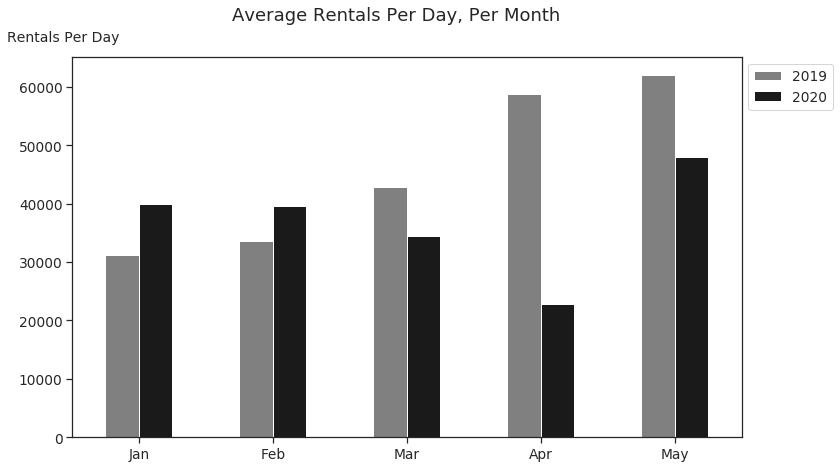

In [23]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'rental_count', 1)
df_pivot = df_pivot.pivot_table(index=['month'], values=[2019, 2020], aggfunc=np.mean)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.05, .91, 'Rentals Per Day', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Average Rentals Per Day, Per Month", fontsize=18)
# plt.title("(CitiBike NYC)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

# TODO
- Discuss findings 
- Determine significance
- Rewrite below sections

#### Shelter-in-place = fewer bike rentals

This view provides a nice picture regarding the timing of the downward trend starting in mid-March and continuing through April. A slight decline is apparent shortly after the pandemic declaration, with a more noticeable shift after the stay-at-home decree.



## 3. What is the effect on rental durations?
<br/>

TBD Section intro



### Total rental duration per month


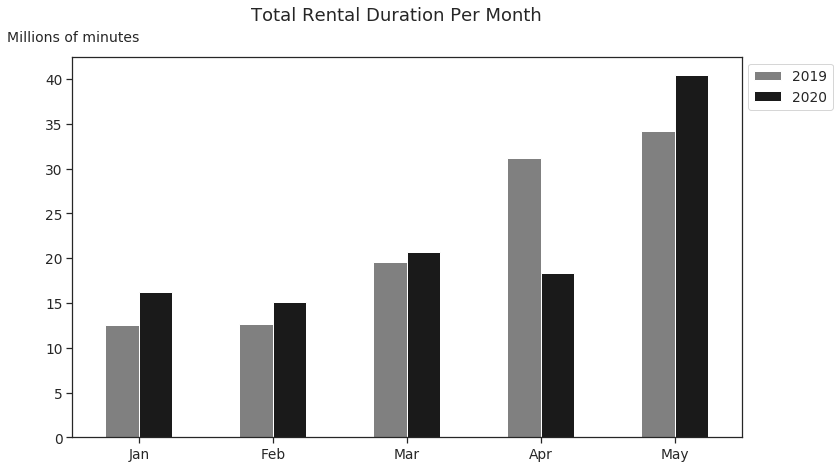

In [24]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month'], ['year'], 'tripduration', 1.667E-8, impute=True)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.05, .91, 'Millions of minutes', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Total Rental Duration Per Month", fontsize=18)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

### Total cumulative rental duration over time

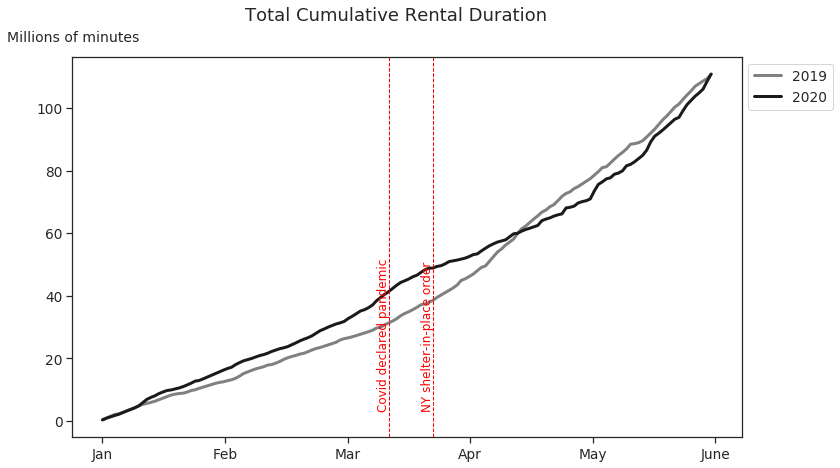

In [25]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'tripduration', 1.667E-8, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=71, color='red', linestyle='--', linewidth=1)
plt.text(68,4,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=82, color='red', linestyle='--', linewidth=1)
plt.text(79,4,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.05, .91, 'Millions of minutes', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Duration", fontsize=18)
plt.xticks(np.linspace(0, 152, num=6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


### Average rental duration by month, 2019 vs. 2020


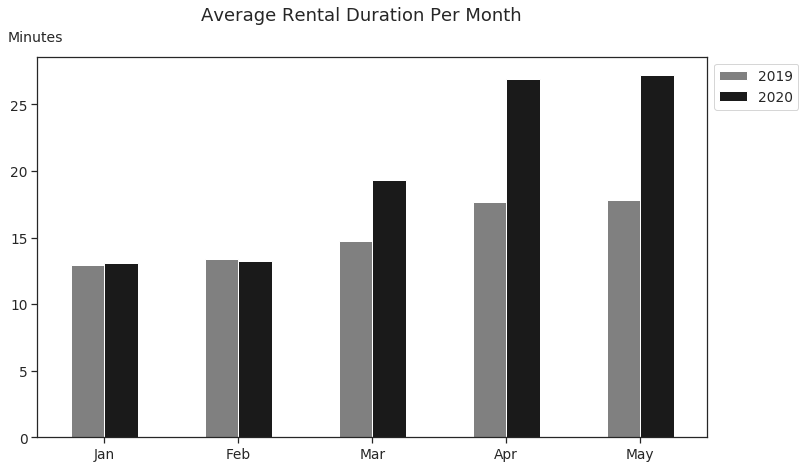

In [26]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month'], ['year'], 'tripduration', 1.667E-2, aggfunc=np.mean)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.09, .91, 'Minutes', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Average Rental Duration Per Month", fontsize=18)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

# TODO
- Discuss findings 
- Determine significance
- Rewrite below sections


#### Duration stays strong despite the pandemic

Looking at the corresponding view for cumulative rental duration, it seems that the affect of the pandemic announcement is less pronounced, with durations only starting to taper down following the shelter-in-place order. Further, the total cumulative duration at the end of April appears to be less impacted than the view of total cumulative rental counts. 

So what does this mean? Are people riding bikes for for longer durations on average during the pandemic than they were prior? Let's dig in and find out. For this analysis, we'll take a look at average rental durations by month for 2019 vs. 2020.

#### Where are people going?

Interesting... while the total number of bike rentals is on the decline, the average rental duration is increasing. This begs the question, *where are people going?*

Some possible theories...
1. People have more time on their hands and biking feels like a safe way to get outside and avoid contact with others (assuming the bikes are sanitized between rides... yikes!)
<br/>

2. With so many businesses shut down and/or with so many items out of stock, people had to travel further than normal to buy food, or more likely, to find toilet paper or hand sanitizer.
<br/>

3. Similar to point 1 above ... with gyms temporarily shut down, rental bikes provide would-be spinners a means of getting their *Soul Cycle* fix  
<br/>

Later on, we can utilize the station info to investigate this question further. For now, let's move on to the next question on our original list... 

## 4. Do age or gender make a difference?

# TODO - Update

Are there any significant, observable patterns in the data along the dimensions of Age Group and Gender ?

Section intro, introduce helper function for plotting 


<br/>

Next on our list is to take a look at our data along the dimensions of age and gender. Starting with gender, we have three categories in our data - male, female and not specified. For age, we can use the birth year field to categorize our riders into three age groups - under 35, 35-55 and over 55.

In keeping with our above analysis, let's see if we can find any patterns in the data that would indicate behavioral changes for these groups related to total rentals or total rental duration.

Before we get started plotting our data, we need a new helper function that will enable us to create subplots for each of our different categories.


### Create and assign age groups


In [27]:
# Create function to return decade for a given year
def assign_age_cat(year):
    """Returns 1 digit age category when passed 4 digit year    
    """
    if (year > 1985) and (year <= 2005):
        age_cat = 0
    elif (year >= 1970) and (year <= 1985):
        age_cat = 1
    elif (year >= 1920) and (year < 1970):
        age_cat = 2
    else:
        age_cat = 3
    return age_cat

In [28]:
# Create new column for age group and populate using the function
df["age_cat"] = df['birth_year'].apply(assign_age_cat)


### Create helper function for multi-dimensional plots


In [29]:
def make_subplots(x_labels, y_labels, y_min, y_max, title, text, text_x=0.05, text_y=0.89, num_plots=3, num_months=5):
    """Returns a multi-dimensional grid of subplots
    """
    # Set x values
    x = [i+1 for i in range(num_months)]

    # Create figure and subplot grid
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

    # Create subplots
    for i in range(num_plots):
        for j in range(num_plots):
            # Extract y values for 2019 and 2020 from pivot table
            y1 = [df_pivot[df_pivot.index.isin([(n+1,i,j)])].iloc[0,0] for n in range(num_months)]
            y2 = [df_pivot[df_pivot.index.isin([(n+1,i,j)])].iloc[0,1] for n in range(num_months)]

            # Create elements to zip y values
            y = [y1, y2]
            labels = ['2019', '2020']
            colors = ['gray', 'k']

            # Plot the values
            ax_loc = ax[i,j]
            for y_arr, label, color in zip(y, labels, colors):
                ax_loc.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')

            # Set x and y tick locations and xticklabels
            ax_loc.set_xticks(np.linspace(1, 5, 5))
            ax_loc.set_ylim(y_min, y_max)
            ax_loc.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'])

            # Set location specific plot elements
            if i == 0 and j == 0: # set yaxis label on upper left plot
                ax[0,0].text(text_x, text_y, text, fontsize=14, transform=plt.gcf().transFigure)
            if j == 0: # set y labels on left plots only
                ax_loc.set_ylabel(y_labels[i], labelpad=16)            
            if i == (num_plots-1): # set xlabels on bottom plots only
                ax_loc.set_xlabel(x_labels[j], labelpad=16)

        # Add legend and show the plot
        ax[0,1].set_title(title, y=1.2, x=0.5, fontsize=18)
        ax[0,2].legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


### Average rental count per month, by gender and age group


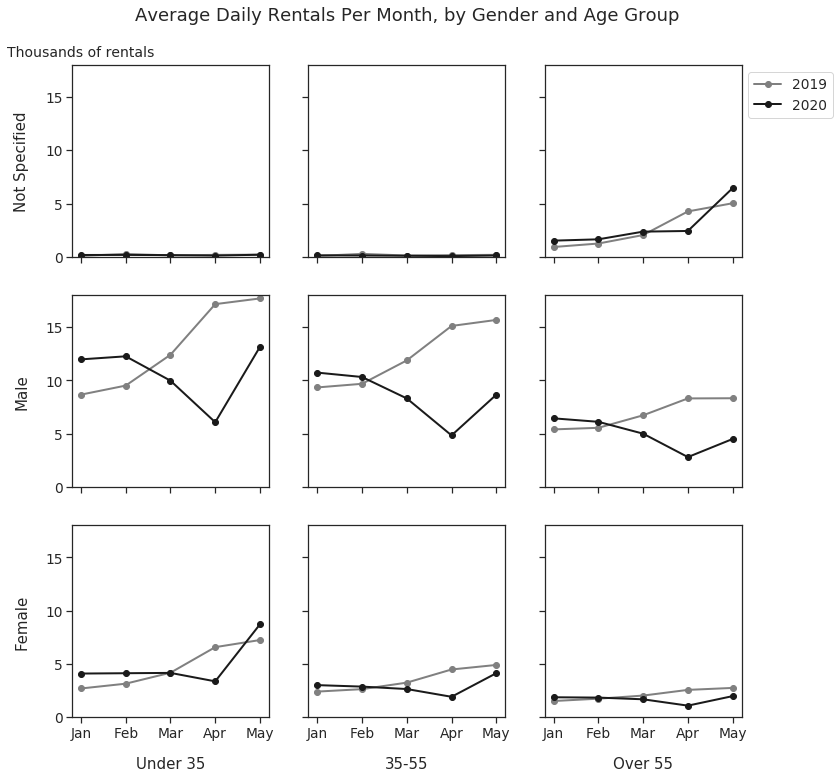

In [30]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day', 'gender', 'age_cat'], ['year'], 'rental_count', .001, impute=True)
df_pivot = df_pivot.pivot_table(index=['month', 'gender', 'age_cat'], values=[2019, 2020])

# Configure variables
x_labels = ['Under 35', '35-55', 'Over 55']
y_labels = ['Not Specified', 'Male', 'Female']
y_min, y_max = 0, 18
title = "Average Daily Rentals Per Month, by Gender and Age Group"
text = "Thousands of rentals"

# Call the helper function to make the subplots
make_subplots(x_labels, y_labels, y_min, y_max, title, text)

### Average daily rental duration per month, by gender and age group

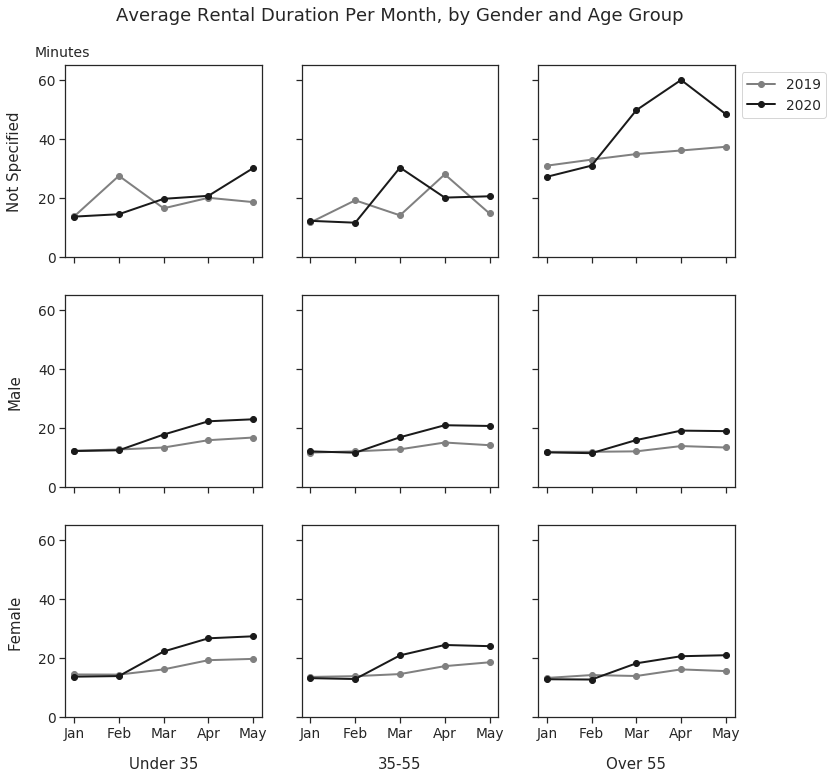

In [31]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day', 'gender', 'age_cat'], ['year'], 'tripduration', 1.667E-2,
                    impute=True, aggfunc=np.mean)
df_pivot = df_pivot.pivot_table(index=['month', 'gender', 'age_cat'], values=[2019, 2020])

# Update variables
y_min, y_max = 0, 65
title = "Average Rental Duration Per Month, by Gender and Age Group"
text = "Minutes"

# Call the helper function to make the subplots
make_subplots(x_labels, y_labels, y_min, y_max, title, text, text_x=0.09)


#### TODO - Summary and result



## 5. Are there any perceptible shifts in rider behavior in terms of rides by hour of day or day of the week?

TBD - Section intro

In [71]:
### Probably can be removed

# # Pivot df using helper function
# df_pivot_19 = df[df.year == 2019] 
# df_pivot_19 = pivot_df(df_pivot_19, ['month', 'day', 'dow', 'hour'], ['year'], ['rental_count', 'tripduration'], 1, 
#                         aggfunc={'rental_count': 'sum', 'tripduration': 'mean'})
# df_pivot_20 = df[df.year == 2020] 
# df_pivot_20 = pivot_df(df_pivot_20, ['month', 'day', 'dow', 'hour'], ['year'], ['rental_count', 'tripduration'], 1, 
#                         aggfunc={'rental_count': 'sum', 'tripduration': 'mean'})
# df_pivot_20

# df_pivot_20 = df_pivot_20.pivot_table(index=['month', 'dow', 'hour'], values=['rental_count', 'tripduration'])
# df_pivot_20


### Average daily rental count per month by day and hour


In [69]:
### TODO - need to replace dow function with is_weekend

# Filter df by year
df_pivot_19 = df[df.year == 2019]
df_pivot_20 = df[df.year == 2020]

# Pivot df using helper function
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'day', 'dow', 'hour'], ['year'], 'rental_count', 1)
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2019],
                       scale=1, aggfunc=np.mean)

df_pivot_20 = pivot_df(df_pivot_20, ['month', 'day', 'dow', 'hour'], ['year'], 'rental_count', 1)
df_pivot_20 = pivot_df(df_pivot_20, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2020],
                       scale=1, aggfunc=np.mean)

df_pivot_20

year              2020
month dow hour        
1     0   0     205.50
          1      92.00
          2      63.75
          3      40.00
          4      69.25
...                ...
5     6   19   4217.20
          20   2543.00
          21   1332.60
          22    921.80
          23    610.20

[840 rows x 1 columns]


### Average daily rental duration per month by day and hour


In [72]:
# Filter df by year
df_pivot_19 = df[df.year == 2019]
df_pivot_20 = df[df.year == 2020]

# Pivot df using helper function
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'day', 'dow', 'hour'], ['year'], 'tripduration', 1.667E-2, 
                       aggfunc=np.mean)
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2019],
                       scale=1, aggfunc=np.mean)

df_pivot_20 = pivot_df(df_pivot_20, ['month', 'day', 'dow', 'hour'], ['year'], 'tripduration', 1.667E-2, 
                       aggfunc=np.mean)
df_pivot_20 = pivot_df(df_pivot_20, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2020],
                       scale=1, aggfunc=np.mean)

df_pivot_20

year            2020
month dow hour      
1     0   0    12.78
          1    10.81
          2     9.20
          3     9.54
          4    11.24
...              ...
5     6   19   26.70
          20   27.80
          21   29.30
          22   29.92
          23   25.76

[840 rows x 1 columns]

In [73]:
df.head()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender,rental_count,hour,day,month,year,dow,age_cat
0,320,3160,3283,0,1971,1,1,0,1,1,2019,1,1
1,316,519,518,0,1964,1,1,0,1,1,2019,1,2
2,591,3171,3154,0,1987,1,1,0,1,1,2019,1,0
3,2719,504,3709,0,1990,1,1,0,1,1,2019,1,0
4,303,229,503,0,1979,1,1,0,1,1,2019,1,1


# Quick review of age hist for curiousity sake

In [75]:
temp_df = df[['birth_year', 'year', 'rental_count']].copy()
temp_df['age'] = temp_df['year'] - temp_df['birth_year']
temp_df.head()

,birth_year,year,rental_count,age
0,1971,2019,1,48
1,1964,2019,1,55
2,1987,2019,1,32
3,1990,2019,1,29
4,1979,2019,1,40


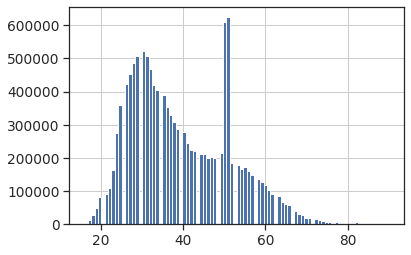

In [77]:
temp_df['age'].hist(bins=90)

## Appendix A: Geographic Data

In [ ]:
# Dictionary of columns and optimal dtypes
col_types = {'start station id' : 'int', 'end station id': 'int',
             'usertype': 'category', 'birth year': 'int', 'gender': 'int8'}

# Create list of columns to drop
drop_cols = ['stoptime', 'start station name', 'start station latitude',
             'start station longitude', 'end station name', 'end station latitude',
             'end station longitude', 'bikeid']

# Read in and process the data
data_files = glob.glob('../data/' + "*.csv")
rentals_dfs = []
station_dfs = []

for file in data_files:
    rentals_df, station_df = read_and_process(file, col_types, drop_cols, get_stations=True)
    rentals_dfs.append(rentals_df)
    station_dfs.append(station_df)

# Concatentate the list of temp dfs
df = pd.concat(rentals_dfs, ignore_index=True)
stations = pd.concat(station_dfs, ignore_index=True).drop_duplicates(subset='id', keep="first")

# Check out the data!
rows = df.shape[0]
print(str(rows) + " Rows")